#**CycleGAN Keras İmplemantasyonu**

***Bu çalışma CycleGAN ile fotoğraflarda kapalı çıkan bir gözün açık haldeki tahminlemesi. Vanilla versiyon.***

#CycleGAN Algoritması

![alt text](https://i.hizliresim.com/qCV8Y0.jpg)




#1-Veri Hazırlama  
CycleGAN doğası gereği pair fotoğraflara ihtiyaç duymaz. Fakat Modelimizin 300 milyon parametre içermesi, büyüklüğü ve eğitim zorluğu beni kendi pair çiftlerimi oluşturmaya itti. Normalin'den tek farkı model göz dışında ki bölgeler için autoencoder'lardaki copy-paste mantığı yapıcak. Gradyanlar ölecek. Computational azalıcak.


23k gözleri açık facedatasetini cv2 kütüphanesinde bulunan Cascade Classifier'ı kullanarak gözlerini tespit ettim ve beyazla boyadım.
 
Fakat ileride sadece 1k'sını kullanıcam.

(source code'a eklediğim veriseti bu işlemin en son halidir)

In [1]:
!nvidia-smi

Mon Jun 15 11:10:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install -q kaggle

In [0]:
!mkdir ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets list

In [0]:
!kaggle datasets download -d abhikjha/utk-face-cropped

In [0]:
!unzip utk-face-cropped.zip -d /content/Photos

In [0]:
cd /content/Photos/utkcropped

In [0]:
!rm -r utkcropped

In [0]:
import os
arr = os.listdir('.')
for i in range(len(arr)):
  os.rename(r'/content/Photos/utkcropped/{}'.format(arr[i]),r'/content/Photos/utkcropped/{}.jpg'.format(str(i)))
  ##dosya isimlerini 0.jpg'den 23708.jpg'ye kadar numaralandırma

In [0]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

eye_cascade = cv2.CascadeClassifier("/content/eyedetection.xml")

In [0]:
def photoisokay(eyes):
  if len(eyes) == 2:
    return True
  else:
    return False

In [0]:
for index in range(len(arr)):

  image_real = cv2.imread(arr[index])
  image_fake = image_real.copy()

  eyes = eye_cascade.detectMultiScale(image_fake,scaleFactor=1.1,minNeighbors=10)

  if not photoisokay(eyes):
    continue

  for (x,y,w,h) in eyes:
    cv2.rectangle(image_fake , (x,y) , (x+w,y+h) , (255,255,255) , -1)


  cv2.imwrite('/content/Real/image{}.jpg'.format(index), image_real)
  cv2.imwrite('/content/Fake/image{}.jpg'.format(index), image_fake)

#CycleGAN

Modeldeki kayıplar optimizer'lar ve çeşitli parametreler orjinal CycleGAN'ın pytorch implementation'ından alınmıştır. Zira bu modeli bile eğitmek 3 gün sürdüğü için gridsearch yapma şansım yok.

CycleGan Sınıfı oluşturdum. Bu sınıfta özellikle staticmethod kullandım. Çünkü self metodlarında fonksiyonlar birbirleriyle haberleşir. Discriminator ve Generator'un, (trainable = True or False) kısmını sürekli ayarlamam gerekicekti ve proje büyüdüğünde içinden çıkılmaz bir hal alıcaktı. Fakat Default halinin true olması sebebiyle sadece kapanmasını istediğim yerlere false eklemem yeterli.

In [3]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-sbndd7ix
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-sbndd7ix
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=c2b601a19785bc695b0ace39944cb709560881220d921613a3c45d06a8ea7317
  Stored in directory: /tmp/pip-ephem-wheel-cache-q9s7owxh/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model, Input
from keras.layers import Conv2D, LeakyReLU, Activation, Concatenate, BatchNormalization, Conv2DTranspose
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.preprocessing.image import img_to_array, load_img
from keras.utils.vis_utils import plot_model
import keras.backend as K
K.clear_session()

import numpy as np
import os
from matplotlib import pyplot

Veri İşlemleri Operasyonları

In [0]:
class DataOperations():

 
  @staticmethod #Resimlerin boyutunu 256,256 yapıp array'e dönüştürüp npz uzantılı kaydeden metod
  def import_and_save_images(name, path, size=(256,256)):  
    data_list = list()
    img_list = os.listdir(path)
    img_list.sort()

    count = 0
    for filename in img_list:
      pixels = load_img(path + filename, target_size=size)
      pixels = img_to_array(pixels)
      data_list.append(pixels)
      count += 1
      if count%1 == 0:
        print(count, ". Appended")
    
    filename = name + '_256.npz'
    np.savez_compressed(path+filename, np.asarray(data_list))
    print('Saved dataset: ', filename)
    return filename

  
  @staticmethod #kaydedilmiş resimleri [-1,1] aralığına sokup geri yükleyen metod
  def load_samples(filename1,filename2):

    file1 = np.load(filename1)
    file1 = file1['arr_0']
    file1 = (file1 - 127.5) / 127.5

    file2 = np.load(filename2)
    file2 = file2['arr_0']
    file2 = (file2 - 127.5) / 127.5

    print('Loaded: ',filename1," and " ,filename2)
    return file1,file2

CycleGAN class'ı.

In [0]:
class CycleGAN():

  @staticmethod #discriminatör modeli
  def define_discriminator(image_shape):
    init_disc = RandomNormal(stddev=0.02) #weight init

    input_image = Input(shape=image_shape)  #input

    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init_disc)(input_image)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init_disc)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init_disc)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init_disc)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init_disc)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    output_image = Conv2D(1, (4,4), padding='same', kernel_initializer=init_disc)(d)

    model = Model(input_image, output_image)
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

  @staticmethod #resnet block of generator
  def resnet_block(n_filters, input_layer):

    init = RandomNormal(stddev=0.02)

    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
  
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)

    g = Concatenate()([g, input_layer])
    return g

  @staticmethod #generator model
  def define_generator(image_shape=(256,256,3), n_resnet=9):

    init = RandomNormal(stddev=0.02)

    in_image = Input(shape=image_shape)

    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    for _ in range(n_resnet):
      g = CycleGAN.resnet_block(256, g)

    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)

    model = Model(in_image, out_image)
    return model

  @staticmethod #Komposit model
  def define_composite_model(g_model_1, d_model, g_model_2, image_shape):

    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False

    # Adverisal Model
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)

    # Identity Model
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)

    # Forward Model
    output_f = g_model_2(gen1_out)

    # Backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)

    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model

  @staticmethod #Veri setinden index'ten gelen fotoğrafı çekmek ve discriminator'e öğretmek
  def generate_real_samples(dataset, n_samples, patch_shape):

    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y
  
  @staticmethod #generator modelden fake foto üretmek ve discriminator'e öğretmek
  def generate_fake_samples(g_model, dataset, patch_shape=16):

    X = g_model.predict(dataset)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

  @staticmethod #Modelin karmaşıklığını arttırmak için pool'a fotoğraf ekleyip rastgele seçim yapmak.
  def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
      
      if len(pool) < max_size:
        pool.append(image)
        selected.append(image)
      
      elif random() < 0.5:
        selected.append(image)
      
      else:
        ix = randint(0, len(pool))
        selected.append(pool[ix])
        pool[ix] = image

    return np.asarray(selected)

  @staticmethod #Modeli ve ağırlıklarını savelemek
  def save_models(step, g_model_AtoB, g_model_BtoA , d_model_A, d_model_B):
    # save the first generator model
    filename1 = '/content/drive/My Drive/PubgVsLife/g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = '/content/drive/My Drive/PubgVsLife/g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)

    filename3 = '/content/drive/My Drive/PubgVsLife/d_model_A_%06d.h5' % (step+1)
    d_model_A.save(filename3)

    filename4 = '/content/drive/My Drive/PubgVsLife/d_model_B_%06d.h5' % (step+1)
    d_model_B.save(filename4)

    print('>Saved: %s and %s and %s and %s' % (filename1, filename2, filename3, filename4))


  @staticmethod #performans özet
  def summarize_performance(step, g_model, trainX, name, n_samples=5):

    X_in, _ = CycleGAN.generate_real_samples(trainX, n_samples, 0)

    X_out, _ = CycleGAN.generate_fake_samples(g_model, X_in, 0)

    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0

    for i in range(n_samples):
      pyplot.subplot(2, n_samples, 1 + i)
      pyplot.axis('off')
      pyplot.imshow(X_in[i])

    for i in range(n_samples):
      pyplot.subplot(2, n_samples, 1 + n_samples + i)
      pyplot.axis('off')
      pyplot.imshow(X_out[i])

    filename1 = '/content/drive/My Drive/PubgVsLife/Photos/%s_generated_plot_%06d.png' % (name, (step+1))
    pyplot.savefig(filename1)
    pyplot.close()

  @staticmethod #train kısmı
  def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, realdata, nrrdata):
    
    n_epochs, n_batch, = 100, 1
    n_patch = d_model_A.output_shape[1]
    
    trainA, trainB = realdata, nrrdata
    poolA, poolB = list(), list()

    n_steps = int(len(trainA)) * n_epochs


    for i in range(n_steps):

      index = np.random.randint(0,1000)


      X_realA, y_realA = CycleGAN.generate_real_samples(trainA, n_batch, n_patch)
      X_realB, y_realB = CycleGAN.generate_real_samples(trainB, n_batch, n_patch)


      X_fakeA, y_fakeA = CycleGAN.generate_fake_samples(g_model_BtoA, X_realB, n_patch)
      X_fakeB, y_fakeB = CycleGAN.generate_fake_samples(g_model_AtoB, X_realA, n_patch)

      #X_fakeA = CycleGAN.update_image_pool(poolA, X_fakeA)
      #X_fakeB = CycleGAN.update_image_pool(poolB, X_fakeB)


      g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])


      dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
      dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)


      g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])


      dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
      dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
  

      print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))


      if (i+1) % int(len(trainA)) == 0:
        CycleGAN.summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
        CycleGAN.summarize_performance(i, g_model_BtoA, trainB, 'BtoA')

        CycleGAN.save_models(i, g_model_AtoB, g_model_BtoA , d_model_A, d_model_B)

      
      #pyplot.imshow(xx[2].astype('uint8'))

#ANA OPERASYONLAR

200x200 veriyi 256x256 ya dönüştürüp .npz olarak kaydettiğimiz kısım

In [21]:
real_path = "/content/drive/My Drive/image1k/Real1k/"
nrr_path = "/content/drive/My Drive/image1k/NotReallyReal1k/"

realName = DataOperations.import_and_save_images("real",real_path,size=(256,256))
nrrName = DataOperations.import_and_save_images("nrr",nrr_path,size=(256,256))

FileNotFoundError: ignored

.npz dosyasından import etmek

In [22]:
path = "/content/drive/My Drive/PubgVsLife/"
lifedata , pubgdata = DataOperations.load_samples(path+"life.npz", path+"pubg.npz")

Loaded:  /content/drive/My Drive/PubgVsLife/life.npz  and  /content/drive/My Drive/PubgVsLife/pubg.npz


İlk çalıştırma için modellerin oluşturulması

In [23]:
image_shape = lifedata.shape[1:]

g_model_AtoB = CycleGAN.define_generator(image_shape)
g_model_BtoA = CycleGAN.define_generator(image_shape)

d_model_A = CycleGAN.define_discriminator(image_shape)
d_model_B = CycleGAN.define_discriminator(image_shape)

c_model_AtoB = CycleGAN.define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoA = CycleGAN.define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

KeyboardInterrupt: ignored

Daha önce çalıştırılmışsa modeli load edip çalıştırmak. Ya üstteki ya alttaki kod çalışır.

In [0]:
import keras.backend as K
K.clear_session()


from keras.models import load_model
cust = {'InstanceNormalization': InstanceNormalization}

g_model_AtoB = load_model('/content/drive/My Drive/PubgVsLife/g_model_AtoB_015892.h5', cust, compile=False)
g_model_BtoA = load_model('/content/drive/My Drive/PubgVsLife/g_model_BtoA_015892.h5', cust, compile=False)

d_model_A = load_model('/content/drive/My Drive/PubgVsLife/d_model_A_015892.h5', cust, compile=True)

d_model_B = load_model('/content/drive/My Drive/PubgVsLife/d_model_B_015892.h5', cust, compile=True)


image_shape = lifedata.shape[1:]
c_model_AtoB = CycleGAN.define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoA = CycleGAN.define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

Train başlasın

In [0]:
if __name__ == "__main__":
  CycleGAN.train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, lifedata, pubgdata)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


#Deneme

In [0]:
for i in range (548):

  listx = []
  listx.append(lifedata[i])
  sample = np.asarray(listx)

  sonuc = g_model_AtoB.predict(sample)
  sonuc = (sonuc + 1) /2
  pyplot.imshow(sonuc[0])
  pyplot.axis('off')
  filename1 = '/content/drive/My Drive/PubgVsLife/8768img/{}.png'.format(i)
  pyplot.savefig(filename1)
  pyplot.close()

for i in range(548):
  org = (lifedata[i]+1)/2
  pyplot.imshow(org)
  pyplot.axis('off')
  filename1 = '/content/drive/My Drive/PubgVsLife/8768img/{}org.png'.format(i)
  pyplot.savefig(filename1)
  pyplot.close()

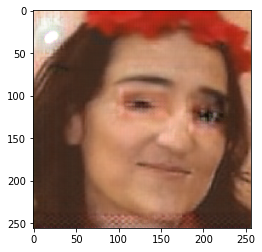

In [0]:
#64 epoch
sample = "/content/77.jpg"
annem = load_img(sample, target_size=(256,256))
annem_array = img_to_array(annem)
listx = []
listx.append(annem_array)
annem_array = np.asarray(listx)
annem_array = (annem_array-127.5)/127.5
sonuc = g_model_BtoA.predict(annem_array)
sonuc = (sonuc + 1) /2
pyplot.imshow(sonuc[0])